# SDSC3001 - Course Project

## Jaccard similarity coefficient

In [1]:
def jaccard_similarity(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)


# Example usage
set1 = {"a", "b", "c", "d"}
set2 = {"c", "d", "e", "f"}

similarity = jaccard_similarity(set1, set2)
print(f"Jaccard Similarity: {similarity}")

Jaccard Similarity: 0.3333333333333333


## Sketching techniques for the Jaccard similarity coefficient

In [2]:
import numpy as np
import random


random_seed = 42
random.seed(random_seed)
# Parameters
k = 128  # Number of hash functions
n = 10_000  # cardinality of the sets

In [3]:
def generate_balanced_synthetic_stream(n, jaccard_true):
    # Calculate sizes
    similarity_coefficient = (2 * jaccard_true) / (1 + jaccard_true)
    intersection_size = int(n * similarity_coefficient)
    unique_elements = n - intersection_size

    stream = []

    # Add intersection elements
    for i in range(intersection_size):
        stream.append(["setA", i])
        stream.append(["setB", i])

    # Add unique elements for set A
    for i in range(intersection_size, intersection_size + unique_elements):
        stream.append(["setA", i])

    # Add unique elements for set B
    for i in range(intersection_size + unique_elements, intersection_size + 2 * unique_elements):
        stream.append(["setB", i])

    # Shuffle the stream to avoid bias
    random.shuffle(stream)

    return stream

In [4]:
def generate_unbalanced_synthetic_stream(n, jaccard_true): ...

In [5]:
import sys
import os

print(os.getcwd() in sys.path)
sys.path.append(os.getcwd())
print(os.getcwd() in sys.path)

False
True


In [6]:
from hashSketch import MinHash, B_bitMinHash, OddSketch, MaxLogHash

### MinHash

### b-bit MinHash

### Odd Sketch

## MaxLogHash

## Datasets

### Synthetic datasets

Generate set A by randomly selecting n different numbers from I

Generate set B by randomly selecting $|A \cup B| = \frac{J_{A, B}|A|}{1+J_{A, B}}$ different numbers from set A and $n - |A \cup B|$ different numbers from set I\A

n = 10,000 by default

- Balanced set-pairs (i.e., |A| = |B| = n)
- Unbalanced set-pairs (i.e., |A| != |B|)

In [7]:
def compare_all_methods(jaccard_true, k=128, n=10000):
    """
    Compare all similarity estimation methods
    jaccard_true: true Jaccard similarity
    k: number of hash functions
    n: number of elements in the stream (cardinality)
    """

    # Generate synthetic stream
    stream = generate_balanced_synthetic_stream(n, jaccard_true)

    # Regular MinHash estimation
    minhash = MinHash(k)
    minhash.process_stream(stream)
    jaccard_est_min = minhash.estimate_similarity()

    # b-bit MinHash estimation
    b = 1  # b-bit MinHash parameter
    bbit_minhash = B_bitMinHash(k, b)
    bbit_minhash.process_stream(stream)
    jaccard_est_bbit = bbit_minhash.estimate_similarity()

    # Odd Sketch estimation
    z = 512  # Odd Sketch size
    odd_sketch = OddSketch(k, z)
    odd_sketch.process_stream(stream)
    jaccard_est_odd = odd_sketch.estimate_similarity()

    # MaxLogHash estimation
    maxlog = MaxLogHash(k)
    maxlog.process_stream(stream)
    jaccard_est_max = maxlog.estimate_similarity()

    # print(f"{jaccard_true}, {jaccard_est_min}, {jaccard_est_bbit}, {jaccard_est_odd}, {jaccard_est_max}")
    return jaccard_est_min, jaccard_est_bbit, jaccard_est_odd, jaccard_est_max

In [8]:
# Initialize an empty list to store results
results = []

for i in range(80, 101):
    jaccard_true = i / 100
    jaccard_est_min, jaccard_est_bbit, jaccard_est_odd, jaccard_est_max = compare_all_methods(jaccard_true)

    # Append the results to the list
    results.append([jaccard_true, jaccard_est_min, jaccard_est_bbit, jaccard_est_odd, jaccard_est_max])

In [9]:
import polars as pl


# Create a DataFrame from the results
columns = ["True Jaccard", "MinHash", "b-bit MinHash", "Odd Sketch", "MaxLogHash"]
df = pl.DataFrame(results, schema=columns, orient="row")

# Display the DataFrame
print(df)

shape: (21, 5)
┌──────────────┬───────────┬───────────────┬────────────┬────────────┐
│ True Jaccard ┆ MinHash   ┆ b-bit MinHash ┆ Odd Sketch ┆ MaxLogHash │
│ ---          ┆ ---       ┆ ---           ┆ ---        ┆ ---        │
│ f64          ┆ f64       ┆ f64           ┆ f64        ┆ f64        │
╞══════════════╪═══════════╪═══════════════╪════════════╪════════════╡
│ 0.8          ┆ 0.7578125 ┆ 0.75          ┆ 0.772943   ┆ 0.090184   │
│ 0.81         ┆ 0.765625  ┆ 0.8125        ┆ 0.772943   ┆ 0.068522   │
│ 0.82         ┆ 0.875     ┆ 0.84375       ┆ 0.80193    ┆ 0.155171   │
│ 0.83         ┆ 0.8828125 ┆ 0.78125       ┆ 0.892902   ┆ 0.014366   │
│ 0.84         ┆ 0.8515625 ┆ 0.8125        ┆ 0.811409   ┆ 0.133509   │
│ …            ┆ …         ┆ …             ┆ …          ┆ …          │
│ 0.96         ┆ 0.96875   ┆ 0.984375      ┆ 0.976283   ┆ 0.079353   │
│ 0.97         ┆ 0.9453125 ┆ 0.953125      ┆ 0.976283   ┆ 0.003535   │
│ 0.98         ┆ 0.984375  ┆ 1.0           ┆ 0.992157   ┆ 0.09

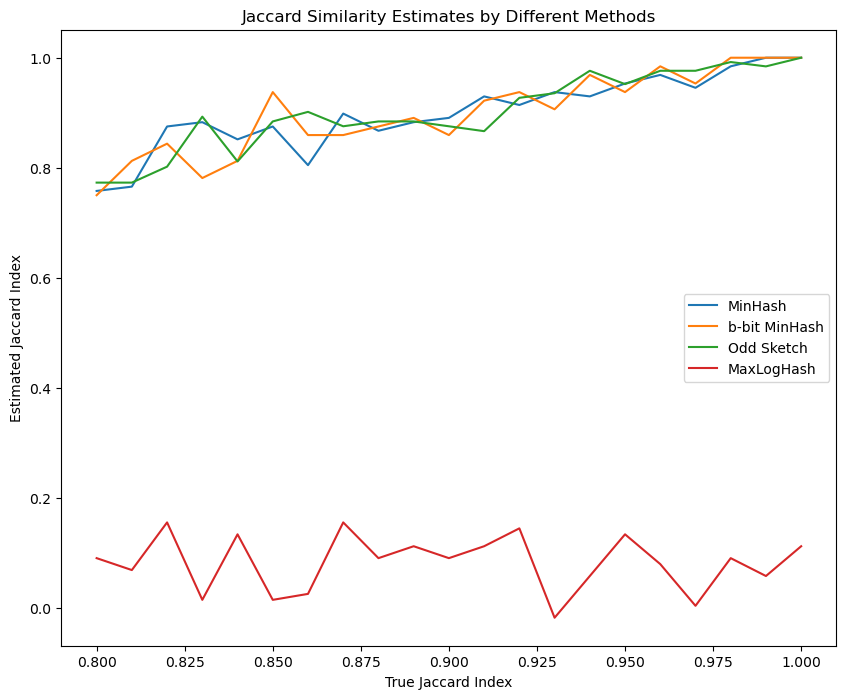

In [10]:
import matplotlib.pyplot as plt

# Set the size of the plot
plt.figure(figsize=(10, 8))

# Plot the data
for method in columns[1:]:
    plt.plot(df["True Jaccard"], df[method], label=method)

# Set the title and labels
plt.title("Jaccard Similarity Estimates by Different Methods")
plt.xlabel("True Jaccard Index")
plt.ylabel("Estimated Jaccard Index")

# Add a legend
plt.legend()

# Show the plot
plt.show()

### Real-world datasets

In [11]:
def load_dataset(filepath):
    stream = []
    with open(filepath, "r") as file:
        for record_id, line in enumerate(file):
            items = [int(x) for x in line.strip().split()]
            for item in items:
                stream.append([record_id, item])
    #     dataset = pl.DataFrame(np.loadtxt(file, dtype=int))

    # item_record_pairs = {}
    # for record_id, record in enumerate(dataset):
    #     for item in record:
    #         if item not in item_record_pairs:
    #             item_record_pairs[item] = []
    #         item_record_pairs[item].append(record_id)
    # pairs = [(item, rec) for item, recs in item_record_pairs.items() for rec in recs]
    # print(dataset.head(5))
    # print(f"{dataset.shape[0]} records with {len(item_record_pairs)} distinct times")
    # print(f"{len(pairs)} item-record pairs")

    return stream

In [ ]:
minhash = MinHash(k)
bbit_minhash = B_bitMinHash(k, b=4)
odd_sketch = OddSketch(k, z=4 * k)
maxlog = MaxLogHash(k)

#### MUSHROOM dataset

- 8,124 records with 119 distinct items
- 186,852 item-record pairs

In [ ]:
mushroom_dataset_path = "./data/mushroom.dat"
mushroom_stream = load_dataset(mushroom_dataset_path)

# mushroom_dataset = mushroom[0]
# mushroom_item_record_pairs = mushroom[1]
# mushroom_pairs = mushroom[2]

# print(mushroom_dataset[:5])
# print(mushroom_dataset.shape)
# print(len(mushroom_item_record_pairs))
# print(len(mushroom_pairs))

In [ ]:
# MinHash estimation
minhash.process_stream(mushroom_stream)
print(minhash.estimate_similarity(0, 1))

# b-bit MinHash estimation
bbit_minhash.process_stream(mushroom_stream)
print(bbit_minhash.estimate_similarity(0, 1))

# Odd Sketch estimation
odd_sketch.process_stream(mushroom_stream)
print(odd_sketch.estimate_similarity(0, 1))

# MaxLogHash estimation
maxlog.process_stream(mushroom_stream)
print(maxlog.estimate_similarity(0, 1))

In [ ]:
# MaxLogHash estimation
maxlog.process_stream(mushroom_stream)
print(maxlog.estimate_similarity(0, 1))
print(maxlog.estimate_similarity(0, 2))
print(maxlog.estimate_similarity(0, 3))
print(maxlog.estimate_similarity(1, 2))
print(maxlog.estimate_similarity(1, 3))
print(maxlog.estimate_similarity(1, 4))

#### CONNECT dataset

- 67,557 records with 127 distinct items
- 2,904,951 item-record pairs

In [ ]:
connect_dataset_path = "./data/connect.dat"
connect_stream = load_dataset(connect_dataset_path)

# connect_dataset = connect[0]
# connect_item_record_pairs = connect[1]
# connect_pairs = connect[2]

# print(connect_dataset[:5])
# print(connect_dataset.shape)
# print(len(connect_item_record_pairs))
# print(len(connect_pairs))

In [ ]:
# # MinHash estimation
# minhash.process_stream(connect_stream)
# print(minhash.estimate_similarity(0, 1))

# # b-bit MinHash estimation
# bbit_minhash.process_stream(connect_stream)
# print(bbit_minhash.estimate_similarity(0, 1))

# # Odd Sketch estimation
# odd_sketch.process_stream(connect_stream)
# print(odd_sketch.estimate_similarity(0, 1))

# # MaxLogHash estimation
# maxlog.process_stream(connect_stream)
# print(maxlog.estimate_similarity(0, 1))